In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse
from scipy.sparse.linalg import svds

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import matplotlib.pyplot as plt

In [2]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))

## 1st Experiment: Skewed populations

Train the collaborative filtering on 1000 F/100 M and 100F/1000M and 1000F/1000M to see the recalls.

In [3]:
ratings = pd.read_csv('ml-1m/ratings.dat', header=None, sep='::', 
                      encoding='latin-1', engine='python', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])
users = pd.read_csv('ml-1m/users.dat', header=None, sep='::',
                    encoding='latin-1', engine='python',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
movies = pd.read_csv('ml-1m/movies.dat', header=None, sep='::',
                     encoding='latin-1', engine='python',
                     names=['movie_id', 'title', 'genres'])

In [4]:
ratings['user_id'] = ratings['user_id'] - 1
ratings['movie_id'] = ratings['movie_id'] - 1
users['user_id'] = users['user_id'] - 1
movies['movie_id'] = movies['movie_id'] - 1

In [5]:
movie_id_to_iid = {movies['movie_id'][i]:i for i in movies.index}
movie_iid_to_id = {i:movies['movie_id'][i] for i in movies.index}

### Filtering the datasets

In [6]:
f_users = users[users['gender'] == 'F']
m_users=  users[users['gender'] == 'M']
print('Number of female users: {}\nNumber of male users: {}'.format(f_users.shape[0], m_users.shape[0]))

Number of female users: 1709
Number of male users: 4331


In [7]:
def df_to_mat(df, item_n, user_n, user_id_to_iid, movie_id_to_iid):
    """
    Convert DataFrame to sparse matrix.

    Arg:
        df: DataFrame, ratings dataframe with user_id, movie_id and rating

    Return:
        mat: scipy.sparse.csr_matrix, sparse ratings matrix with rows being items and cols being users
    """
    
    mat = sparse.lil_matrix((item_n, user_n))
    for _, row in df.iterrows():
        user_id = int(row[0])
        item_id = int(row[1])
        user_iid = user_id_to_iid[user_id]
        item_iid = movie_id_to_iid[item_id]
        rating = row[2]
        mat[item_iid, user_iid] = rating
    
    return mat 

In [8]:
def cb_recommend(user_id, topk, user_id_to_iid, movie_iid_to_id, item_user_mat, knn, X_tfidf, item_n):

    user_iid = user_id_to_iid[user_id]
    user_ratings = item_user_mat[:, user_iid]
    rated_before = np.nonzero(user_ratings)[0]
    sorted_rated_before = rated_before[np.argsort(user_ratings[rated_before].toarray().squeeze())][::-1]

    if sorted_rated_before.size > 0:

        raw_recommends = {}
        for item_iid in sorted_rated_before:
            distances, indices = knn.kneighbors(X_tfidf[item_iid], n_neighbors=topk+1)
            sorted_pairs = sorted(list(zip(indices.squeeze().tolist(),
                                           distances.squeeze().tolist())),
                                    key=lambda x: x[1])
            raw_recommends[item_iid] = sorted_pairs
        
        top_items = []
        pos = 0
        while True:
            for item_iid in sorted_rated_before:
                next_neighbor_iid = raw_recommends[item_iid][pos][0]
                if next_neighbor_iid not in rated_before:
                    top_items.append(movie_iid_to_id[next_neighbor_iid])
                if len(top_items) > topk - 1:
                    return (user_id, np.array(top_items))
            
            pos += 1
    
    else:
        top_items = list(map(lambda x: movie_iid_to_id[x], random.sample(list(range(0, item_n)), topk)))
        return (user_id, np.array(top_items))

In [9]:
def cf_recommend(user_id, topk, user_id_to_iid, known_rating_mat, est_rating_mat):
    
    user_iid = user_id_to_iid[user_id]
    user_ratings = known_rating_mat[user_iid, :]
    rated_before = np.nonzero(user_ratings)[1]
    estimations = est_rating_mat[user_iid, :].copy()
    estimations[rated_before] = 0

    top_item_iids = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]

    top_item_ids = [movie_iid_to_id[i] for i in top_item_iids]

    return (user_id, np.array(top_item_ids))

In [103]:
def run_experiment_1(n_epochs, n_female, n_male):

    all_f_cf_r = []
    all_m_cf_r = []

    for epoch in range(n_epochs):
    
        f_user_ids = f_users.sample(n_female)['user_id'].to_numpy()
        m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

        sampled_ratings = ratings[ratings['user_id'].isin(f_user_ids) | ratings['user_id'].isin(m_user_ids)]
        sampled_user_ids = sampled_ratings['user_id'].unique()
        user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
        user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

        user_n = sampled_ratings['user_id'].nunique()
        item_n = movies['movie_id'].nunique()

        train_df, test_df = train_test_split(sampled_ratings, test_size=0.2)
    
        item_user_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
        item_user_mat = item_user_mat.tocsr()
    
        # collaborative filtering
        # mf = NMF(n_components=50, init='random', random_state=0, max_iter=500, verbose=False)
        mf = TruncatedSVD(n_components=10, n_iter=10)
        known_rating_mat = item_user_mat.T
        user_f = mf.fit_transform(known_rating_mat)
        item_f = mf.components_.T
        est_rating_mat = np.dot(user_f, item_f.T)

        test_mat = df_to_mat(test_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
    
        f_cf_r = []

        for user_id in f_user_ids:
            user_iid = user_id_to_iid[user_id]
            test_items_iids = list(np.argwhere(test_mat[:, user_iid] >= 4)[:, 0])
            test_items = list(map(lambda x: movie_iid_to_id[x], test_items_iids))

            if len(test_items) > 0:
                top_items = list(cf_recommend(user_id,10, user_id_to_iid, known_rating_mat, est_rating_mat)[1])

                recall = Recall(test_items, top_items)
                f_cf_r.append(recall)
    
        all_f_cf_r.append(np.average(f_cf_r))

        m_cf_r = []

        for user_id in m_user_ids:
            user_iid = user_id_to_iid[user_id]
            test_items_iids = list(np.argwhere(test_mat[:, user_iid] >= 4)[:, 0])
            test_items = list(map(lambda x: movie_iid_to_id[x], test_items_iids))

            if len(test_items) > 0:
                top_items = list(cf_recommend(user_id,10, user_id_to_iid, known_rating_mat, est_rating_mat)[1])

                recall = Recall(test_items, top_items)
                m_cf_r.append(recall)
    
        all_m_cf_r.append(np.average(m_cf_r))
    
    return (all_f_cf_r, all_m_cf_r)
    

In [104]:
epochs = 20

In [105]:
# 20 epochs of 100 female + 1000 female
all_f_cf_r_11, all_m_cf_r_11 = run_experiment_1(epochs, 100, 1000)

c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 re

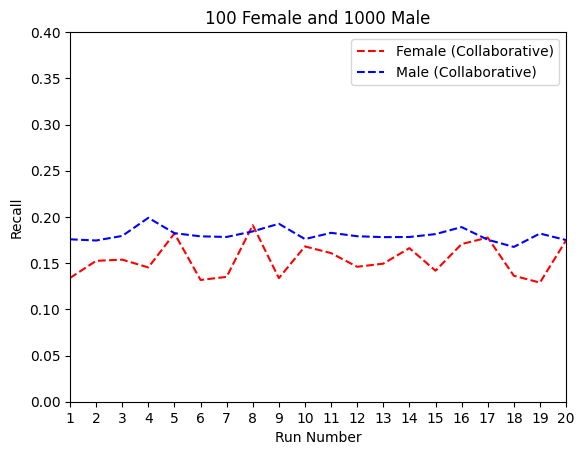

In [106]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs)+1, all_f_cf_r_11, 'r--', label='Female (Collaborative)')
ax.plot(np.arange(epochs)+1, all_m_cf_r_11, 'b--', label='Male (Collaborative)')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,epochs])
ax.set_ylim([0, 0.4])
ax.set_xlabel('Run Number')
ax.set_ylabel('Recall')
plt.xticks(range(1,epochs+1))
plt.title('100 Female and 1000 Male')
plt.show()

In [338]:
print('100 Female:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cf_r_11), np.std(all_f_cf_r_11)))
print('1000 Male:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cf_r_11), np.std(all_m_cf_r_11)))

100 Female:
- Average Recall: 0.154
- Standard Deviation: 0.018
1000 Male:
- Average Recall: 0.180
- Standard Deviation: 0.007


In [107]:
# 20 epochs of 1000 female + 100 male
all_f_cf_r_12, all_m_cf_r_12 = run_experiment_1(epochs, 1000, 100)

c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 re

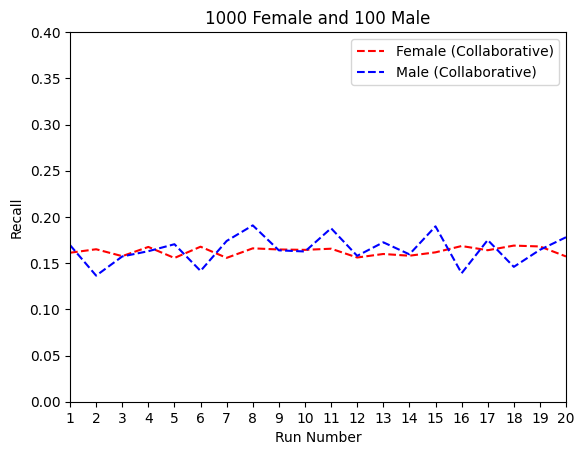

In [108]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs)+1, all_f_cf_r_12, 'r--', label='Female (Collaborative)')
ax.plot(np.arange(epochs)+1, all_m_cf_r_12, 'b--', label='Male (Collaborative)')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,epochs])
ax.set_ylim([0, 0.4])
ax.set_xlabel('Run Number')
ax.set_ylabel('Recall')
plt.xticks(range(1,epochs+1))
plt.title('1000 Female and 100 Male')
plt.show()

In [339]:
print('1000 Female:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cf_r_12), np.std(all_f_cf_r_12)))
print('100 Male:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cf_r_12), np.std(all_m_cf_r_12)))

1000 Female:
- Average Recall: 0.163
- Standard Deviation: 0.005
100 Male:
- Average Recall: 0.165
- Standard Deviation: 0.016


In [109]:
# 20 epochs of 1000 female + 1000 male
all_f_cf_r_13, all_m_cf_r_13 = run_experiment_1(epochs, 1000, 1000)

c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 re

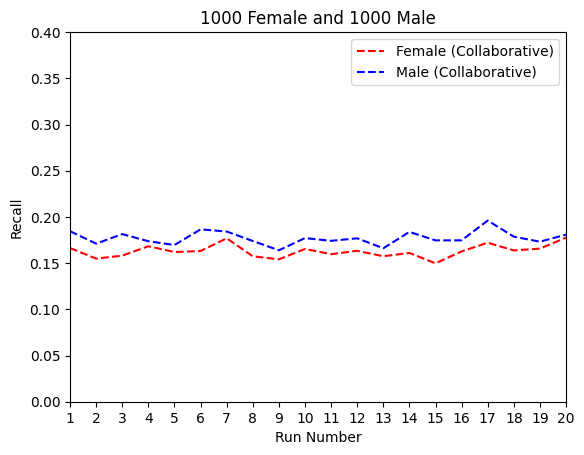

In [110]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs)+1, all_f_cf_r_13, 'r--', label='Female (Collaborative)')
ax.plot(np.arange(epochs)+1, all_m_cf_r_13, 'b--', label='Male (Collaborative)')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,epochs])
ax.set_ylim([0, 0.4])
ax.set_xlabel('Run Number')
ax.set_ylabel('Recall')
plt.xticks(range(1,epochs+1))
plt.title('1000 Female and 1000 Male')
plt.show()

In [340]:
print('1000 Female:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cf_r_13), np.std(all_f_cf_r_13)))
print('1000 Male:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cf_r_13), np.std(all_m_cf_r_13)))

1000 Female:
- Average Recall: 0.163
- Standard Deviation: 0.007
1000 Male:
- Average Recall: 0.177
- Standard Deviation: 0.007


## Experiment 2 Inspecting the influence on item ratings

Train the collaborative filtering on skewed populations, check estimated ratings for certain movies under different circumstances.

In [10]:
# find the top 50 most popular movies
top_movie_ids = ratings.movie_id.value_counts().iloc[:50].index.to_numpy()
top_movie_ids.sort()
top_movie_ids

array([   0,   33,   49,  109,  259,  295,  317,  355,  456,  479,  526,
        540,  588,  592,  607,  779,  857,  918,  923, 1096, 1126, 1192,
       1195, 1196, 1197, 1199, 1209, 1213, 1220, 1239, 1258, 1264, 1269,
       1386, 1579, 1616, 2027, 2354, 2395, 2570, 2627, 2715, 2761, 2790,
       2857, 2915, 2986, 2996, 3174, 3577], dtype=int64)

In [11]:
# sample 1000 female users, fixed
f_user_ids = f_users.sample(1000)['user_id'].to_numpy()

In [12]:
# get the female users' ratings for top 50 movies
f_top_ratings = ratings[ratings.user_id.isin(f_user_ids) & ratings.movie_id.isin(top_movie_ids)]

In [13]:
f_real_top_ratings = f_top_ratings.groupby('movie_id')['rating'].mean()

In [14]:
def run_experiment_2(n_epochs, n_male, f_user_ids, top_movie_ids):

    avg_f_est_top_ratings = []
    avg_m_est_top_ratings = []
    
    for epoch in range(n_epochs):
    
        m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

        sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
        sampled_user_ids = sampled_ratings['user_id'].unique()
        user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
        user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

        user_n = sampled_ratings['user_id'].nunique()
        item_n = movies['movie_id'].nunique()

        test_df = sampled_ratings[(sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids))]
        train_df = sampled_ratings[~((sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids)))]
    
        item_user_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
        item_user_mat = item_user_mat.tocsr()
    
        # collaborative filtering
        # mf = NMF(n_components=50, init='random', random_state=0, max_iter=500, verbose=False)
        mf = TruncatedSVD(n_components=50, n_iter=10)
        known_rating_mat = item_user_mat.T
        user_f = mf.fit_transform(known_rating_mat)
        item_f = mf.components_.T
        est_rating_mat = np.dot(user_f, item_f.T)

        # test_mat = df_to_mat(test_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
    
        top_movie_iids = [movie_id_to_iid[i] for i in top_movie_ids]
        f_user_iids = [user_id_to_iid[i] for i in f_user_ids]

        f_est_top_ratings = est_rating_mat[np.ix_(np.array(f_user_iids), np.array(top_movie_iids))].mean(axis=0)
        avg_f_est_top_ratings.append(f_est_top_ratings)

        m_user_iids = [user_id_to_iid[i] for i in m_user_ids]
        m_est_top_ratings = est_rating_mat[np.ix_(np.array(m_user_iids), np.array(top_movie_iids))].mean(axis=0)
        avg_m_est_top_ratings.append(m_est_top_ratings)
    
    return (np.array(avg_f_est_top_ratings).mean(axis=0),np.array(avg_m_est_top_ratings).mean(axis=0))

In [15]:
# 1000 male users
f_est_top_ratings_1, m_est_top_ratings_1 = run_experiment_2(20, 1000, f_user_ids, top_movie_ids)

KeyboardInterrupt: 

In [ ]:
# 250 male users
f_est_top_ratings_2, m_est_top_ratings_2 = run_experiment_2(20, 250, f_user_ids, top_movie_ids)

c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 re

In [ ]:
# 4000 male users
f_est_top_ratings_3, m_est_top_ratings_3 = run_experiment_2(20, 4000, f_user_ids, top_movie_ids)

c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Programs\Anaconda3\envs\active-learning\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 500 re

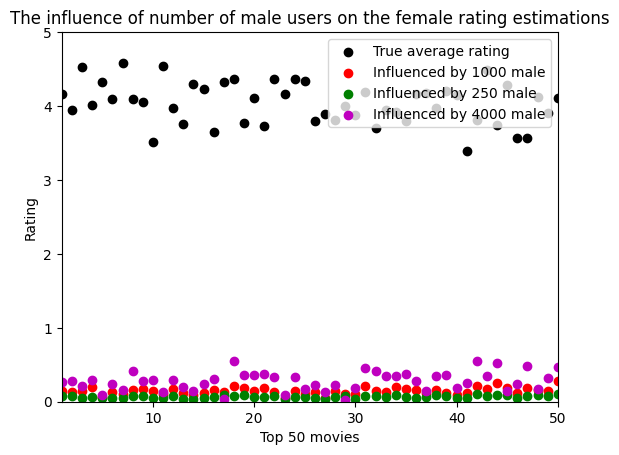

In [192]:
fig, ax = plt.subplots()
ax.scatter(np.arange(50)+1, f_real_top_ratings, c='k', label='True average rating')
ax.scatter(np.arange(50)+1, f_est_top_ratings_1, c='r', label='Influenced by 1000 male')
ax.scatter(np.arange(50)+1, f_est_top_ratings_2, c='g', label='Influenced by 250 male')
ax.scatter(np.arange(50)+1, f_est_top_ratings_3, c='m', label='Influenced by 4000 male')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,50])
ax.set_ylim([0,5])
ax.set_xlabel('Top 50 movies')
ax.set_ylabel('Rating')
plt.title('The influence of number of male users on the female rating estimations')
plt.show()

In [25]:
n_male = 1000
m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
sampled_user_ids = sampled_ratings['user_id'].unique()
user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

user_n = sampled_ratings['user_id'].nunique()
item_n = movies['movie_id'].nunique()

test_df = sampled_ratings[(sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids))]
train_df = sampled_ratings[~((sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids)))]

item_user_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
item_user_mat = item_user_mat.tocsr()
known_rating_mat = item_user_mat.T.toarray()

# mf = NMF(n_components=200, init='random', random_state=0, max_iter=200, verbose=False)
mf = TruncatedSVD(n_components=10, algorithm='arpack', tol=0.0)
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

est_ratings = []
for _, row in test_df.iterrows():
    user_id = row[0]
    movie_id = row[1]

    user_iid = user_id_to_iid[user_id]
    movie_iid = movie_id_to_iid[movie_id]

    est = est_rating_mat[user_iid, movie_iid]

    est_ratings.append(est)
test_df['est'] = np.array(est_ratings)

f_est_top_ratings_1 = test_df.groupby('movie_id')['est'].mean()

C:\Users\sky_l\AppData\Local\Temp\ipykernel_2064\1012295461.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['est'] = np.array(est_ratings)


In [26]:
n_male = 250
m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
sampled_user_ids = sampled_ratings['user_id'].unique()
user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

user_n = sampled_ratings['user_id'].nunique()
item_n = movies['movie_id'].nunique()

test_df = sampled_ratings[(sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids))]
train_df = sampled_ratings[~((sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids)))]

item_user_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
item_user_mat = item_user_mat.tocsr()
known_rating_mat = item_user_mat.T.toarray() #

# mf = NMF(n_components=200, init='random', random_state=0, max_iter=200, verbose=False)
# mf = TruncatedSVD(n_components=50, n_iter=100, random_state=0)
mf = TruncatedSVD(n_components=10, algorithm='arpack', tol=0.0)
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

est_ratings = []
for _, row in test_df.iterrows():
    user_id = row[0]
    movie_id = row[1]

    user_iid = user_id_to_iid[user_id]
    movie_iid = movie_id_to_iid[movie_id]

    est = est_rating_mat[user_iid, movie_iid]

    est_ratings.append(est)
test_df['est'] = np.array(est_ratings)

f_est_top_ratings_2 = test_df.groupby('movie_id')['est'].mean()

C:\Users\sky_l\AppData\Local\Temp\ipykernel_2064\3419435237.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['est'] = np.array(est_ratings)


In [27]:
n_male = 4000
m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
sampled_user_ids = sampled_ratings['user_id'].unique()
user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

user_n = sampled_ratings['user_id'].nunique()
item_n = movies['movie_id'].nunique()

test_df = sampled_ratings[(sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids))]
train_df = sampled_ratings[~((sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids)))]

item_user_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid, movie_id_to_iid)
item_user_mat = item_user_mat.tocsr()
known_rating_mat = item_user_mat.T.toarray() #

# mf = NMF(n_components=200, init='random', random_state=0, max_iter=200, verbose=False)
# mf = TruncatedSVD(n_components=50, n_iter=100, random_state=0)
mf = TruncatedSVD(n_components=10, algorithm='arpack', tol=0.0)
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

est_ratings = []
for _, row in test_df.iterrows():
    user_id = row[0]
    movie_id = row[1]

    user_iid = user_id_to_iid[user_id]
    movie_iid = movie_id_to_iid[movie_id]

    est = est_rating_mat[user_iid, movie_iid]

    est_ratings.append(est)
test_df['est'] = np.array(est_ratings)

f_est_top_ratings_3 = test_df.groupby('movie_id')['est'].mean()

C:\Users\sky_l\AppData\Local\Temp\ipykernel_2064\869572213.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['est'] = np.array(est_ratings)


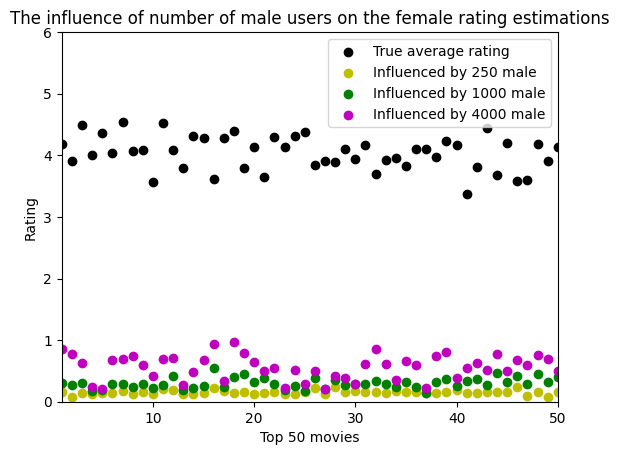

In [28]:
fig, ax = plt.subplots()
ax.scatter(np.arange(50)+1, f_real_top_ratings, c='k', label='True average rating')
ax.scatter(np.arange(50)+1, f_est_top_ratings_2, c='y', label='Influenced by 250 male')
ax.scatter(np.arange(50)+1, f_est_top_ratings_1, c='g', label='Influenced by 1000 male')
ax.scatter(np.arange(50)+1, f_est_top_ratings_3, c='m', label='Influenced by 4000 male')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,50])
ax.set_ylim([0,6])
ax.set_xlabel('Top 50 movies')
ax.set_ylabel('Rating')
plt.title('The influence of number of male users on the female rating estimations')
plt.show()